In [172]:
import numpy as np
import numpy.matlib
import math
from scipy.optimize import fsolve

# for testing
datasize_x = 255
datasize_y = 255

# parameters
L = 0.5  # Length (before strain)
N = 50  # Spatial resolution
E = 207e9  # Young's modulus
r = 0.001  # Cross-section radius
rt1 = np.mat([[0.02], [0], [0]])
rt2 = np.mat([[-0.02], [0], [0]])
rho = 8000  # Density
g = np.mat([[-9.81], [0], [0]])  # Gravity
Bse = np.matlib.zeros(3)  # Material damping coefficients - shear and extension
Bbt = 1e-2 * np.eye(3)  # Material damping coefficients - bending and torsion
C = 0.1 * np.eye(3)
dt = 0.04  # Time step
alpha = -0.2  # BDF-alpha parameter
STEPS = 202  # Number of timesteps to completion
vstar = np.array([[0], [0], [1]])  # Value of v when static and absent loading
ustar = np.array([[0], [0], [0]])  # Precurvature
vsstar = np.array([[0], [0], [0]])
usstar = np.array([[0], [0], [0]])
    
# Boundary Conditions
p = np.zeros((STEPS, N), dtype=object)
R = np.zeros((STEPS, N), dtype=object)
q = np.zeros((STEPS, N), dtype=object)
w = np.zeros((STEPS, N), dtype=object)
# global p, R, q, w
for i in range(0, STEPS):    # from 1 to STEPS
    p[i][0] = np.matlib.zeros((3,1))
    R[i][0] = np.matlib.eye(3)
    q[i][0] = np.matlib.zeros((3,1))
    w[i][0] = np.matlib.zeros((3,1))
    
nL = np.mat([[0], [0], [0]])
mL = np.mat([[0], [0], [0]])

# Dependent Parameter Calculations
A = math.pi*r**2    # Cross-sectional area
J = np.diag([math.pi*r**4/4, math.pi*r**4/4, math.pi*r**4/2])  # Inertia
G = 80e9    # shear modulus
Kse = np.mat(np.diag([G*A, G*A, E*A]))   # Stiffness matrix - shear and extension
Kbt = np.mat(np.diag([E*J[0, 0], E*J[1, 1], G*J[2, 2]]))    # Stiffness matrix - bending and torsion
ds = L/(N-1)    # Grid distance (before strain)
c0 = (1.5 + alpha) / ( dt*(1+alpha) )   # BDF-alpha coefficients
c1 = -2 / dt
c2 = (0.5 + alpha) / (dt * (1 + alpha))
d1 = alpha / (1 + alpha)

n = np.empty([datasize_x,datasize_y], dtype = object)
m = np.empty([datasize_x,datasize_y], dtype = object)

u = np.empty([datasize_x,datasize_y], dtype = object)
uh = np.empty([datasize_x,datasize_y], dtype = object)
us = np.empty([datasize_x,datasize_y], dtype = object)
ush = np.empty([datasize_x,datasize_y], dtype = object)
ust = np.empty([datasize_x,datasize_y], dtype = object)
ut = np.empty([datasize_x,datasize_y], dtype = object)

v = np.empty([datasize_x,datasize_y], dtype = object)
vh = np.empty([datasize_x,datasize_y], dtype = object)
vs = np.empty([datasize_x,datasize_y], dtype = object)
vsh = np.empty([datasize_x,datasize_y], dtype = object)
vst = np.empty([datasize_x,datasize_y], dtype = object)
vt = np.empty([datasize_x,datasize_y], dtype = object)

w = np.empty([datasize_x,datasize_y], dtype = object)
wh = np.empty([datasize_x,datasize_y], dtype = object)
wt = np.empty([datasize_x,datasize_y], dtype = object)

x = np.empty([datasize_x,datasize_y], dtype = object)
y = np.empty([datasize_x,datasize_y], dtype = object)
z = np.empty([datasize_x,datasize_y], dtype = object)


qh = np.empty([datasize_x,datasize_y], dtype = object)
qt = np.empty([datasize_x,datasize_y], dtype = object)


In [156]:
def hat(y_in):
    y = np.zeros((3,3))
    y[0][1] = -y_in[2]
    y[0][2] = y_in[1]
    y[1][0] = y_in[2]
    y[1][2] = -y_in[0]
    y[2][0] = y_in[1]
    y[2][1] = y_in[0]
    y = np.mat(y)
    return y

In [157]:
def find_tension():
    global i
    t = (i-2)*dt
    
    P_desire = np.mat([[0.25*((1-math.exp(-2*t)))],[0],[0]])
    Pd_desire = np.mat([[0.25*((2*math.exp(-2*t)))],[0],[0]])
    Pdd_desire = np.mat([[0.25*((-4*np.exp(-2*t)))],[0],[0]])
    
    p_dot1 = R[i-1][N-1]*(hat(u[i-1][N-1])*rt1 + v[i-1][N-1])
    p_ddot1 = R[i-1][N-1]*(hat(u[i-1][N-1])*hat(u[i-1][N-1])*rt1 + v[i-1][N-1])+hat(us[i-1][N-1])*rt1 + vs[i-1][N-1]
    alph1 = (hat(p_dot1)*hat(p_dot1)*p_ddot1)/(np.linalg.norm(p_dot1)**3)
    alph11 = (p_dot1)/(np.linalg.norm(p_dot1))
    
    alphM = alph1 + alph11
    
    ac = (ns + rho*A*g - R[i-1][N-1]*abs(q[i-1][N-1]))/(rho*A)
    bc = -(alphM)/(rho*A)
    
    X_end = p[i-1][N]
    Xd_end = R[i-1][N]* q[i-1][N]
    
    alpa1 = 64.7
    alpa2 = 10
    
    Z1 = P_desire - X_end
    Z2 = Xd_end - Pd_desire - alpa1*Z1
    
    bc_inv = np.mat(np.linalg.inv(bc))
    TT = bc_inv*(Z1-ac-alpa1*(Z2+alpa1*Z1)-alpa2*Z2+Pdd_desire)
    
    if TT > 87:
        TT = 87
    
    e = P_desire - X_end
    e_dot = Pd_desire - Xd_end
    

In [158]:
def staticODE(p, R, n, m):
    Rt = np.mat(np.transpose(R))
    
    # v = Kse\ R' * n + vstar[ds*(j-1)]
    inv_Kse = np.mat(np.linalg.inv(Kse))
    v = inv_Kse*Rt* n + vstar
    
    # u = Kbt\R'*m + ustar(ds*(j-1)) 
    inv_Kbt = np.mat(np.linalg.inv(Kbt))
    u = inv_Kbt*Rt*m + ustar
    
    ptsb = hat(u)*rt1 + v # mat
    Tt = 0
    At = -Tt/np.linalg.norm(ptsb)**3*hat(ptsb)*hat(ptsb)  # mat
#     print("At", At)
#     print(type(At))
    B = hat(rt1)*At
    Gt = -At*hat(rt1)
    H = -B* hat(rt1)
    a = At*(hat(u)*ptsb)
    b = hat(rt1)*a
    
    fe = 0*rho*A*g
    d = Kse*vsstar-hat(u)*Kse*(v-vstar)-a-Rt*fe
    c = Kbt*usstar-hat(u)*Kbt*(u-ustar)-hat(v)*Kse*(v-vstar)-b
    
    Mat_0_0 = np.mat(Kse+At)
    Mat_line_0 = np.concatenate((Kse+At,Gt), axis=1)
    Mat_line_1 = np.concatenate((B, Kbt+H), axis=1)
    Mat = np.concatenate((Mat_line_0,Mat_line_1),axis=0)
    
    # vs = 1/np.linalg.det(Mat)*((Kbt+H)*d-Gt*c)
    Mat_det = np.linalg.det(Mat)
    vs = 1/Mat_det*((Kbt+H)*d)-Gt*c
    # us = 1/det(Mat)*(-B*d+(Kse+At)*c)
    us = 1/Mat_det*(-B*d+(Kse+At)*c)
    
    ps = R*v
    Rs = R*hat(u)
    ns = np.mat([[0], [0], [0]])
    ns = -fe
    ms = -hat(ps)*n
    
    return ps, Rs, ns, ms, vs, us, v, u

In [159]:
def staticIVP(g):
    global n, m, vs, us, v, u
    G = np.zeros((6,1))
    for k in range(0,6):
        G[k] = g[k]
#     print(G)
    n[i][j] = G[0:3]
    m[i][j] = G[3:6]
    
    # Euler's method
    for j in range(0, N-1):
        ps, Rs, ns, ms, vs[i][j], us[i][j], v[i][j], u[i][j] = staticODE(p[i][j], R[i][j], n[i][j], m[i][j])
        p[i][j+1] = p[i][j] + ds* ps
        R[i][j+1] = R[i][j] + ds* Rs
        n[i][j+1] = n[i][j] + ds* ns
        m[i][j+1] = m[i][j] + ds* ms
    
    E = np.concatenate((n-nL, m-mL),axis = 0)
#     print("E_shape: ", E.shape)
    
    return E

In [161]:
def applyStaticBDFalpha():
    global v, u, vs, us, vh, uh, vsh, ush
    for j in range (0, N-2):
        vh[i+1][j] = (c1 + c2)*v[i][j]
        uh[i+1][j] = (c1 + c2)*u[i][j]
        vsh[i+1][j] = (c1 + c2)*vs[i][j]
        ush[i+1][j] = (c1 + c2)*us[i][j]
        qh[i+1][j] = [[0],[0],[0]]
        wh[i+1][j] = [[0],[0],[0]]
        q[i][j] = [[0],[0],[0]]
        w[i][j] = [[0],[0],[0]]

In [162]:
def applyDynamicBDFalpha():
    global vh, us, vsh, ush, qh, wh
    for j in range(0, N-2):
        vh[i+1][j] = c1*v[i][j] + c2*v[i-1][j]+d1*vt[i][j]
        uh[i+1][j] = c1*u[i][j] + c2*u[i-1][j]+d1*ut[i][j]
        vsh[i+1][j] = c1*vs[i][j] + c2*vs[i-1][j]+d1*vst[i][j]
        ush[i+1][j] = c1*us[i][j] + c2*us[i-1][j]+d1*ust[i][j]
        qh[i+1][j] = c1*q[i][j] + c2*q[i-1][j]+d1*qt[i][j]
        wh[i+1][j] = c1*w[i][j] + c2*w[i-1][j]+d1*wt[i][j]

In [178]:
def dynamicIVP(g,j):
    global n, m, ps, Rs, ns, qs, ws, vs, us, v, u, vt, ut, qt, wt, vst, ust, p, R
    G = np.zeros((6,1))
#     print(G)
    for k in range(0,6):
        G[k] = g[k]
    n[i][j] = G[0:3]
    m[i][j] = G[3:6]
    
    # Euler's method
    for j in range(0, N-2):
        ps, Rs, ns, ms, qs, ws, vs[i][j], us[i][j],
        v[i][j], u[i][j], vt[i][j], ut[i][j],
        qt[i][j], wt[i][j], vst[i][j], ust[i][j] = dynamicODE(p[i][j],R[i][j],n[i][j],m[i][j],q[i][j],w[i][j])
        p[i][j+1] = p[i][j] + ds*ps
        R[i][j+1] = R[i][j] + ds*Rs
        n[i][j+1] = n[i][j] + ds*ns
        m[i][j+1] = m[i][j] + ds*ms
        q[i][j+1] = q[i][j] + ds*qs
        w[i][j+1] = w[i][j] + ds*ws
    
    E = [[n[i][N]-nLL],[m[i][N]-mLL]]

In [274]:
def dynamicODE(p, R, n, m, q, w):
    Rt = np.transpose(R)
    # v = (Kse + c0*Bse)\(R'*n + Kse*vstar(ds*(j-1)) - Bse*vh{i,j})
    Kse_inv = np.linalg.inv(Kse + c0*Bse)
    v = Kse_inv*(Rt*n+Kse*vstar-Bse*vh[i][j])
    
    # u = (Kbt + c0*Bbt)\(R'*m + Kbt*ustar(ds*(j-1)) - Bbt*uh{i,j})
    Kbt_inv = np.linalg.inv(Kbt + c0*Bbt)
    u = Kbt_inv*(Rt*m + Kbt*ustar - Bbt*uh[i][j])
    vt = c0*v + vh[i][j]
    ut = c0*v + uh[i][j]
    qt = c0*v + qh[i][j]
    wt = c0*v + wh[i][j]
    
    ptsb1 = hat(u)*rt1+v
    At1 = (-Tt1*hat(ptsb1)*hat(ptsb1))/(np.linalg.norm(ptsb1)**3)
    Bt1 = hat(rt1)*At1
    Gt1 = -At1*hat(rt1)
    H1 = -Bt1*hat(rt1)
    a1 = At1*(hat(u)*ptsb1)
    b1 = hat(rt1)*a1
    
    ptsb2 = hat(u)*rt2+v
    At2 = (-Tt2*hat(ptsb2)*hat(ptsb2))/(np.linalg.norm(ptsb2)**3)
    Bt2 = hat(rt2)*At2
    Gt2 = -At2*hat(rt2)
    H2 = -Bt2*hat(rt2)
    a2 = At2*(hat(u)*ptsb2)
    b2 = hat(rt2)*a2
    
    a = a1 + a2
    b = b1 + b2
    At = At1 + At2
    Bt = Bt1 + Bt2
    Gt = Gt1 + Gt2
    H = H1 + H2
    
    LamdaN = -a + rho*A*(hat(w)*q + qt) + np.multiply(C*q,abs(q))-Rt*rho*A*g
    LamdaM = -b + rho*(hat(w)*J*w + J*wt) - hat(v)*(Kse*(v-vstar)+Bse*vt)
    GammaN = hat(u)*(Kse*(v-vstar)+Bse*vt) - Kse*vsstar + Bse*vsh[i][j]
    GammaM = hat(u)*(Kbt*(u-ustar)+Bbt*ut) - Kbt*usstar + Bbt*ush[i][j]
    
#     Mat = [[Kse+c0*Bse+At, Gt],[Bt, Kbt+c0*Bbt+H]]
    Mat_line_0 = np.concatenate((Kse+At,Gt), axis=1)
    Mat_line_1 = np.concatenate((Bt, Kbt+c0*Bbt+H), axis=1)
    Mat = np.concatenate((Mat_line_0,Mat_line_1),axis=0)
    
    Mat_det = np.linalg.det(Mat)
    vs = 1/Mat_det*((Kbt+c0*Bbt+H)*(-GammaN+LamdaN)-Gt*(-GammaM+LamdaM))
    us = 1/Mat_det*(-Bt*(-GammaN+LamdaN)+(Kse+c0*Bse+At)*(-GammaM+LamdaM))
    
    vst = c0*vs+vsh[i][j]
    ust =  0*us+ush[i][j]
    
    pts1 = R*hat(u)*rt1+R*v
    pts2 = R*hat(u)+R*v
    
    nLL = -Tt1*pts1/np.linalg.norm(pts1)-Tt2*pts2/np.linalg.norm(pts2)
    mLL = -Tt1*hat(R*rt1)*pts1/np.linalg.norm(pts1)-Tt2*hat(R*rt2)*pts2/np.linalg.norm(pts2)
    
    ps = R*v
    Rs = R*hat(u)
    
    if i >3:
        fe = rho*A*g
    else:
        fe = 0*rho*A*g
    
    ns = rho*A*R*(hat(w)*q+qt) - R*(a+At*vs+Gt*us)-fe
    ms = -R*(b+Bt*vs+H*us)+rho*R*(hat(w)*J*w+J*wt) - np.cross(ps,n,axis=0)
    qs = vt-hat(u)*q+hat(w)*v
    ws = ut-hat(u)*w
    
    print(Mat_det)

# Testing

In [275]:
p = np.mat([[0],[0],[0]])
R = np.matlib.eye(3)
n = np.mat([[0],[0],[0]])
m = np.mat([[0],[0],[0.1490e-7]])
q = np.mat([[0],[0],[0]])
w = np.mat([[0],[0],[0]])
i = 2
j = 1
vh[i][j] = np.mat([[0],[0],[-40.6250]])
uh[i][j] = np.mat([[0],[0],[-0.4817e-6]])
qh[i][j] = np.mat([[0],[0],[0]])
wh[i][j] = np.mat([[0],[0],[0]])
vsh[i][j] = np.mat([[0],[0],[0]])
ush[i][j] = np.mat([[0],[0],[0]])

Tt1 = 0
Tt2 = 0
dynamicODE(p,R,n,m,q,w)

7069719203310071.0


In [234]:
G = [0,0,0,0,0,0]
print(i)
i=1
j = 0
E = dynamicIVP(G, j)

2


ValueError: could not broadcast input array from shape (3,1) into shape (1,1)

In [196]:
from scipy.optimize import fsolve

# main simulation
i = 0

x0 = np.zeros((6,1))
n = x0[0:3]
m = x0[3:6]

j = 0


ps, Rs, ns, ms, vs[i][j], us[i][j], v[i][j], u[i][j] = staticODE(p[i][j], R[i][j], n, m)
p[i][j+1] = p[i][j] + np.dot(ds, ps)
R[i][j+1] = R[i][j] + np.dot(ds, Rs)
n = n + np.dot(ds, ns)
m = m + np.dot(ds, ms)

E = np.concatenate((n[i][j]-nL, m[i][j]-mL),axis = 0)

# print(E)

ValueError: shapes (3,1) and (3,1) not aligned: 1 (dim 1) != 3 (dim 0)

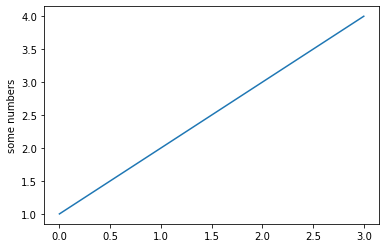

In [261]:
import matplotlib.pyplot as plt
plt.plot([1,2,3,4])
plt.ylabel("some numbers")
plt.show()